In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

from scipy import interpolate
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.misc import imread

In [13]:
def make_historical_diagram():
    '''
    do all of the stuff for the graphics of making a hurricane plot
    
    takes in the year dataframe in order to get the necessary data
    
    returns ax which is the figure axis that the current hurricane track will be added upon
    '''
    # establish the figure
    figure = plt.figure(figsize=(19.2, 12.0), dpi=100)
    
    axis = figure.add_subplot(111)
    axis.set_facecolor("#000000")
    
#     figure, axis = plt.subplots(figsize=(19.2,12.00), dpi=100)
    
#     data = np.linspace(165.0, 0, 10000).reshape(100,100)
# #     data = np.clip(randn(250, 250), -1, 1)

#     histo_image = axis.imshow(data, interpolation='nearest', cmap="inferno")
    
#     divider = make_axes_locatable(axis)
    
#     cax = divider.append_axes("right", size="2%", pad=0.05)

#     # Add colorbar, make sure to specify tick locations to match desired ticklabels
#     cbar = figure.colorbar(histo_image, ticks=[157, 130, 111, 96, 74, 39, 0], cax=cax)
#     cbar.ax.set_yticklabels(['5^', '4^', '3^', '2^', '1^', 'T.S.^', 'T.D.^'])  # vertically oriented colorbar
#     axis.set_title("North American Hurricane Tracks " + str(_year), size=20)
#     axis.set_xlabel("Longitude", size=16)
#     axis.set_ylabel("Latitude", size=16)
#     axis.set_facecolor("black")
    axis.set_xlim(-120.0, -30.0)
    axis.set_ylim(10, 50.0)
    
    return figure, axis
    
def heatmap(ax, storm):
    '''
    make a heatmap of storm track?
    '''
    x, y = storm_heat(storm)
    
    ax.hexbin(x, y, gridsize=50, bins="log", cmap="inferno")
    
    # ax.hexbin(x, y, gridsize=50, bins='log', cmap='inferno')
    
def storm_heat(storm):
    '''
    make storm track into two lists that will be turned into a heatmap
    '''
    _x = []
    _y = []
    
    if len(storm) >= 5:
        interpolation_multiplier = 120

        _lat = storm.Latitude.apply(lambda x: float(x))
        _long = storm.Longitude.apply(lambda x: float(x))

#         _strengths = storm.loc[:,"Wind(WMO)"].apply(lambda x: int(((x / 165.0) * 5.0)**2))
        
        # since the 'saffir_simpson_cat' column ranges from -1 to 5 add 2 to it
        # so that the range is 1 <-> 7 which a computer understands better
        _strengths = storm.loc[:, "saffir_simpson_cat"].apply(lambda x: int((x + 2)**2))
        
        new_length = interpolation_multiplier * len(_lat)

        x = np.arange(len(_lat))

        # figure out length of new arrays
        new_x = np.linspace(x.min(), x.max(), new_length)

        # actually do the interpolation
        new_lat = interpolate.interp1d(x, _lat, kind='cubic')(new_x)
        new_long = interpolate.interp1d(x, _long, kind='cubic')(new_x)
        new_strs = interpolate.interp1d(x, _strengths, kind='cubic')(new_x)
        
        for idx in range(len(new_lat)):
            _strength = int(new_strs[idx])
            for idy in range(_strength):
                _x.append(new_long[idx])
                _y.append(new_lat[idx])

    return _x, _y

def safsimpsonize(wind):
    '''
    Takes in wind speed
    
    Returns saffir-simpson hurricane category with 0 and -1 for tropical storm/depression
    which doesn't make perfect sense as scales go but this maintains categories but allows
    the model/visualization to detect when something is a tropical depression
    
    According to: https://en.wikipedia.org/wiki/Saffir%E2%80%93Simpson_scale
    
    Return:  Category:   Wind Speed Range: (mph, seriously?)
    5        Cat 5      157 <= v
    4        Cat 4      130 <= v < 157
    3        Cat 3      111 <= v < 130
    2        Cat 2      96 <= v < 111
    1        Cat 1      74 <= v < 96
    0        Storm      39 <= v < 74
    -1       Depression v < 39
    '''
    if wind >= 157:
        return 5
    elif wind >= 130:
        return 4
    elif wind >= 111:
        return 3
    elif wind >= 96:
        return 2
    elif wind >= 74:
        return 1
    elif wind >= 39:
        return 0
    else:
        return -1

def load_hurricane_data(_path="../data/allstorms.csv"):
    data = pd.read_csv(_path)

    # data dictionary
    # N/A,Year,#,BB,BB,N/A,YYYY-MM-DD HH:MM:SS,N/A,deg_north,deg_east,kt,mb,N/A,%,%,N/A

    data.loc[:,"Season"] = data.loc[:,"Season"].apply(lambda x: int(x))

#     print data.loc[:,"Basin"].unique()
    # array(['BB', ' SI', ' NA', ' EP', ' SP', ' WP', ' NI', ' SA'], dtype=object)

    data.loc[:, "Basin"] = data.loc[:, "Basin"].apply(lambda x: x.replace(" ", ""))

#     print data.loc[:,"Basin"].unique()
    # ['BB' 'SI' 'NA' 'EP' 'SP' 'WP' 'NI' 'SA']

    data_na = data[data.loc[:, "Basin"] == "NA"]
    
    data_na.loc[:,"saffir_simpson_cat"] = data_na["Wind(WMO)"].apply(lambda x: safsimpsonize(x))

    # try to give back memory
    del data
    
    return data_na

def get_data_as_yearlist(start_year, end_year):
    '''
    take in data frame (north atlantic most likely) and turn it into a list of dataframes
    with each entry being a dataframe holding a year's data
    '''
    # load data frame that we want
    data_na = load_hurricane_data()
    
    # make a list for the years
    years = []

    # step through the Seasons (years) and make a new dataframe for each one
    for year in data_na.loc[:, "Season"].unique():
        temp = data_na[data_na.loc[:, "Season"] == year]
        years.append(temp)

    # get rid of a nan DataFrame
    years.pop(0)

    #loop through years in future gif
    start = 164 - (2016 - start_year)
    end = 164 - (2016 - end_year)
    
    if start != end:
        temp = years[start:end]
    else:
        # handle case where only one year is wanted
        temp = []
        temp.append(years[start])
    
    # try to give back memory
    del years
    
    return temp

def get_storms_from_year(year_df):
    '''
    year_df is the dataframe with a year's data
    
    returns a list of smaller dataframes each consisting of a 
    unique storm track
    '''
    storms = []
    
    # step through the year and make a dataframe for each storm
    for storm in year_df.loc[:,"Serial_Num"].unique():
        storms.append(year_df[year_df.loc[:, "Serial_Num"] == storm])
        
    return storms

draw hex grid on canvas!
max of first: 252
draw hex grid on canvas!
max of first: 252
draw hex grid on canvas!
max of first: 252
draw hex grid on canvas!
max of first: 252
draw hex grid on canvas!
max of first: 252


KeyboardInterrupt: 

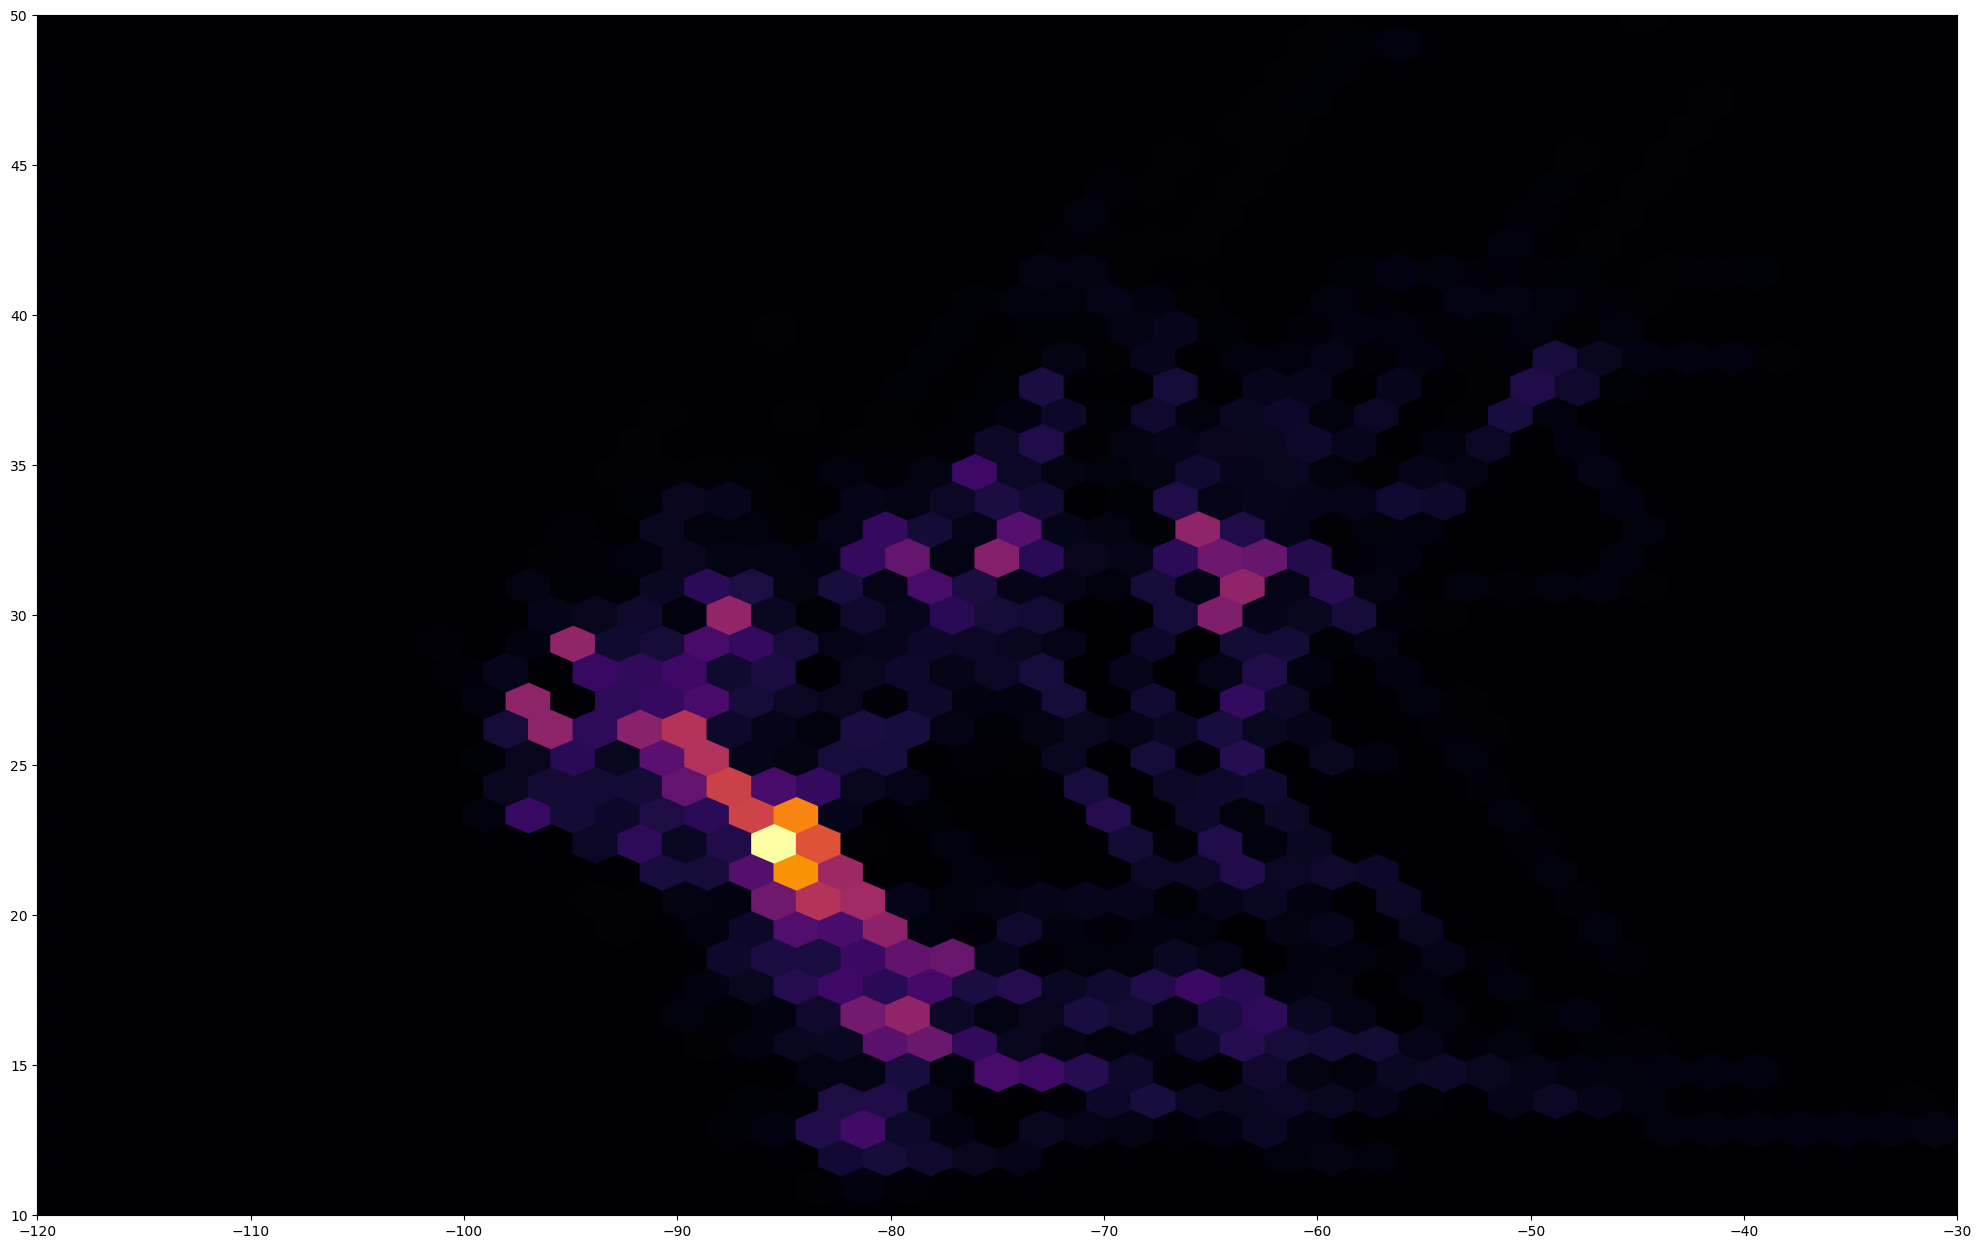

In [71]:
for super_year in range(100):
    
    # establish the range of years
    _start = 1905 + super_year
    _end = 1915 + super_year

    # make a list of year dataframes for the range
    years = get_data_as_yearlist(_start, _end)
    
    map_image = imread("../data/grey_blue_na_2.png")

    storms = []

    big_x = []
    big_y = []

    # make a temp list to hold the storm dataframes from a single year
    for _idx, year in enumerate(years):

        storms = get_storms_from_year(year)

        for storm in storms:

            x, y = storm_heat(storm)

            big_x += x
            big_y += y

        x = np.array(big_x)
        y = np.array(big_y)

    #     ax.clear()
    _year = year.loc[:, "Season"].unique()[0]

    # figure out what the year is    
    _filename = "heatmap{:0>3}".format(super_year)

    # establish the figure
    fig = plt.figure(figsize=(19.2, 12.0), dpi=100)

    ax = fig.add_subplot(111)
    ax.set_facecolor("#000000")
    
    ax.set_xlim(-10.0, -30.0)
    ax.set_ylim(10, 50.0)

    fig.subplots_adjust(0, 0, 1, 1)

    # Draw the empty axis, which we use as a base.
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    _buffer = np.frombuffer(fig.canvas.buffer_rgba(), np.uint8)
    
    # the first buffer which is used for the new track in color
    first = _buffer.astype(np.int16).reshape(h, w, -1) #int16 so we dont overflow
    first[first[:, :, -1] == 0] = 0 # Set transparent pixels to 0

    print "draw hex grid on canvas!"
    
    ax.clear()  # maybe clear erases some of the axis settings, not just the canvas?
    ax.set_xlim(-120.0, -30.0)
    ax.set_ylim(10, 50.0)
    ax.patch.set_facecolor('#000000')
    
    # apply the drawing to the axis so we can pull it out of the buffer in a bit
    ax.hexbin(x, y, gridsize=(43, 21), bins=250, cmap="inferno", extent=[-120, -30, 10, 50])

    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.buffer_rgba(), np.uint8).astype(np.int16).reshape(h, w, -1)
    img[img[:, :, -1] == 0] = 0
    first += img # Add these particles to the main layer

    print "max of first:", first[:,:,0].max()
    
    first = np.clip(first, 0, 255) # clip buffer back into int8 range
                        # wonder if some kind of exp transform
                        # might enable hdr-like effect      

    for a in range(first.shape[0]):
        for b in range(first.shape[1]):
            if first[a][b][0] <= 1 and first[a][b][1] <= 1 and first[a][b][2] <= 1:
                first[a][b][3] = 0
                
                

#             if ((first[a][b][0] + first[a][b][1] + first[a][b][2]) / 3.0) < 5.0 :
#                 first[a][b][3] = 0.2
                
#             if ((first[a][b][0] + first[a][b][1] + first[a][b][2]) / 3.0) < 25.0 :
#                 first[a][b][3] = 0.4
                
#             if ((first[a][b][0] + first[a][b][1] + first[a][b][2]) / 3.0) < 100.0 :
#                 first[a][b][3] = 0.6

    ax.clear()  # maybe clear erases some of the axis settings, not just the canvas?
    ax.set_xlim(-120.0, -30.0)
    ax.set_ylim(10, 50.0)
#     ax.patch.set_facecolor('#000000')

    ax.imshow(map_image, extent=[-120, -30, 10, 50], aspect="auto")
    ax.imshow(first.astype(np.uint8), extent=[-120, -30, 10, 50], aspect='auto', alpha=0.7)

    ax.annotate(str(_year), xy=(-119, 48), size=40, color='#707070')

    fig.savefig("../imgs/test/{}".format(_filename), pad_inches=0, transparent=True)

    plt.close("all")

    del first, big_x, big_y, x, y




In [46]:
for super_year in range(100):
    
    # establish the range of years
    _start = 1915
    _end = _start + super_year

    # make a list of year dataframes for the range
    years = get_data_as_yearlist(_start, _end)
    
    map_image = imread("../data/grey_blue_na_2.png")

    storms = []

    big_x = []
    big_y = []

    # make a temp list to hold the storm dataframes from a single year
    for _idx, year in enumerate(years):

        storms = get_storms_from_year(year)

        for storm in storms:

            x, y = storm_heat(storm)

            big_x += x
            big_y += y

        x = np.array(big_x)
        y = np.array(big_y)

    #     ax.clear()
    _year = year.loc[:, "Season"].unique()[0]

    # figure out what the year is    
    _filename = "heatmap{:0>3}".format(super_year)

    # establish the figure
    fig = plt.figure(figsize=(19.2, 12.0), dpi=100)

    ax = fig.add_subplot(111)
    ax.set_facecolor("#000000")
    
    ax.set_xlim(-120.0, -30.0)
    ax.set_ylim(10, 50.0)

    fig.subplots_adjust(0, 0, 1, 1)

    # Draw the empty axis, which we use as a base.
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    _buffer = np.frombuffer(fig.canvas.buffer_rgba(), np.uint8)
    
    # the first buffer which is used for the new track in color
    first = _buffer.astype(np.int16).reshape(h, w, -1) #int16 so we dont overflow
    first[first[:, :, -1] == 0] = 0 # Set transparent pixels to 0

    print "draw hex grid on canvas!"
    
    ax.clear()  # maybe clear erases some of the axis settings, not just the canvas?
    ax.set_xlim(-120.0, -30.0)
    ax.set_ylim(10, 50.0)
    ax.patch.set_facecolor('#000000')
    
    # apply the drawing to the axis so we can pull it out of the buffer in a bit
    ax.hexbin(x, y, gridsize=(60, 30), bins=50, cmap="inferno", extent=[-120, -30, 10, 50])

    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.buffer_rgba(), np.uint8).astype(np.int16).reshape(h, w, -1)
    img[img[:, :, -1] == 0] = 0
    first += img # Add these particles to the main layer

    print "min of first:", first[:,:,0].min()
    
    first = np.clip(first, 0, 255) # clip buffer back into int8 range
                        # wonder if some kind of exp transform
                        # might enable hdr-like effect   
            
    _before_mean = first[:,:,3].mean()

    for a in range(first.shape[0]):
        for b in range(first.shape[1]):
            # too punishing except for on log scale
#             first[a][b][3] = (first[a][b][0] + first[a][b][1] + first[a][b][2]) / 3.0
            
            if first[a][b][0] <= 5 and first[a][b][1] <= 5 and first[a][b][2] <= 5:
                first[a][b][3] = 0

            elif first[a][b][0] <= 15 and first[a][b][1] <= 15 and first[a][b][2] <= 15:
                first[a][b][3] = 32
                
            elif first[a][b][0] <= 30 and first[a][b][1] <= 30 and first[a][b][2] <= 30:
                first[a][b][3] = 64
                
            elif first[a][b][0] <= 45 and first[a][b][1] <= 45 and first[a][b][2] <= 45:
                first[a][b][3] = 128
    
    _after_mean = first[:,:,3].mean()
    
    print "mean alpha before:{} after:{}".format(_before_mean, _after_mean)

    ax.clear()  # maybe clear erases some of the axis settings, not just the canvas?
    ax.set_xlim(-120.0, -30.0)
    ax.set_ylim(10, 50.0)
#     ax.patch.set_facecolor('#000000')

    ax.imshow(map_image, extent=[-120, -30, 10, 50], aspect="auto")
    ax.imshow(first.astype(np.uint8), extent=[-120, -30, 10, 50], aspect='auto', alpha=0.6)

    ax.annotate(str(_year), xy=(-119, 48), size=40, color='#707070')

    fig.savefig("../imgs/test/small_heat/heat_{}".format(_filename), pad_inches=0, transparent=True)

    plt.close("all")

    del first, big_x, big_y, x, y, _buffer




draw hex grid on canvas!
min of first: 0
mean alpha before:255.0 after:10.1905351563
draw hex grid on canvas!
min of first: 0
mean alpha before:255.0 after:10.1905351563


3.29 4.80 2.42 2.58 3.56 2.66 3.31 3.87 2.47 2.12 4.13 3.27 1.81 4.56 2.48 4.65 1.52 3.07 3.01 2.37 1.28 3.00 3.10 2.44 2.98 0.69 3.97 3.83 2.82 3.88 3.16 2.76 2.39 2.40 4.65 5.10 3.49 2.85 2.50 2.23 2.76 3.02 1.98 3.43 2.53 2.27 2.31 1.30 1.95 3.99 5.62 3.35 2.53 4.68 3.76 2.04 3.18 2.50 4.99 6.24 4.16 3.63 2.95 3.38 3.77 4.03 3.94 2.45 1.21 2.64 2.68 0.96 5.37 4.24 2.44 3.35 4.31 4.57 2.69 3.70 4.20 3.08 2.03 4.51 2.90 3.60 2.18 4.53 3.25 2.96 4.89 5.02 3.12 3.57 2.90 3.17 2.78 3.35 5.20 2.75
-0.572108760122 6.67424354767


(array([   2.,    4.,    3.,    3.,    6.,   10.,   23.,   27.,   39.,
          39.,   78.,  108.,  121.,  176.,  204.,  232.,  281.,  325.,
         358.,  421.,  507.,  495.,  536.,  596.,  562.,  568.,  536.,
         568.,  518.,  440.,  411.,  361.,  278.,  255.,  210.,  172.,
         139.,  118.,   65.,   66.,   40.,   38.,   20.,   17.,    6.,
           7.,    6.,    1.,    3.,    1.]),
 array([-0.57210876, -0.42718171, -0.28225467, -0.13732762,  0.00759942,
         0.15252647,  0.29745352,  0.44238056,  0.58730761,  0.73223466,
         0.8771617 ,  1.02208875,  1.16701579,  1.31194284,  1.45686989,
         1.60179693,  1.74672398,  1.89165102,  2.03657807,  2.18150512,
         2.32643216,  2.47135921,  2.61628626,  2.7612133 ,  2.90614035,
         3.05106739,  3.19599444,  3.34092149,  3.48584853,  3.63077558,
         3.77570262,  3.92062967,  4.06555672,  4.21048376,  4.35541081,
         4.50033786,  4.6452649 ,  4.79019195,  4.93511899,  5.08004604,
         5.22497

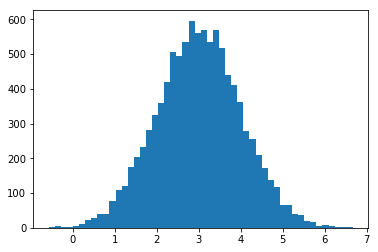

In [67]:
norm_mu, norm_sigma = 3.0, 1.0


distro = np.random.normal(norm_mu, norm_sigma, 10000)
for item in distro[:100]:
    print "{:2.2f}".format(item), 
    
print
print distro.min(), distro.max()
fix, bx = plt.subplots()
bx.hist(distro, bins=50)

In [70]:
for x in range(100):
    print np.random.randint(1, 12),

2 9 3 10 5 4 10 4 8 6 6 7 2 6 8 3 9 5 10 7 7 4 4 11 6 4 6 3 5 1 1 3 5 6 2 1 3 11 3 5 4 1 9 3 10 5 5 9 9 1 3 1 6 9 6 5 8 1 2 1 9 5 7 1 6 1 5 4 2 10 2 6 1 8 2 11 8 8 11 8 1 5 8 1 8 3 8 4 6 4 6 5 4 3 11 2 11 2 10 3


In [ ]:
norm_mu, norm_sigma = 1.0, 0.5
np.random.normal